In [2]:
import os
import re
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Set the directory where the prediction files are stored
results_dir = "../../../LABS/LEAVEOUT/results/rmse_tables"
files = glob.glob(os.path.join(results_dir, "extrapolation_leaveout_*.csv"))
print(f"Found {len(files)} prediction files.")

Found 39 prediction files.


In [3]:
all_pred_dfs = []
pattern = r"extrapolation_leaveout_(.+)\.csv"  # to extract the combination string

for file in files:
    match = re.search(pattern, os.path.basename(file))
    if match:
        combo_str = match.group(1)  # e.g., "10" or "8_10_12"
        # Convert underscore-separated string into a list of integers.
        leaveout_list = [int(s) for s in combo_str.split("_")]
        df = pd.read_csv(file)
        df["leaveout_combo"] = combo_str
        df["n_left"] = len(leaveout_list)
        df["leftout_ids"] = str(leaveout_list)
        all_pred_dfs.append(df)
    else:
        print(f"Filename {file} does not match expected pattern.")

# Concatenate all predictions.
all_predictions = pd.concat(all_pred_dfs, ignore_index=True)
print("Total rows loaded:", len(all_predictions))


Total rows loaded: 282949


Summary metrics per experiment:
      rmse_eb  rmse_rch    mape_eb   mape_rch  n_expts  \
0    4.856946  0.107348   4.671099   3.784780     1257   
1   24.336106  1.005240  17.820962  33.604257     8957   
2   26.436732  0.651511  16.881444  19.102690     7700   
3   30.786632  0.518755  23.629537  16.355747     6420   
4   20.939827  0.317187  13.368270   7.801032     5136   
5   33.359437  0.311530  26.458368   8.545240     3851   
6    9.494545  0.147024   6.837507   4.893017     2564   
7    6.217465  0.121418   4.776408   4.074688     1279   
8    5.069910  0.072886  10.360955   4.133817     1285   
9   29.922792  1.037305  62.809133  61.842510     2523   
10  21.436024  1.502180  33.686647  91.193065     4626   
11  38.494521  1.212426  62.094905  75.383186     5919   
12  33.308469  1.139273  48.896590  65.109672     7037   
13  38.710769  1.051821  56.275673  55.506817     8277   
14  37.653597  0.964787  50.867928  47.399945     9534   
15  34.106773  0.951207  44.318486  44.4

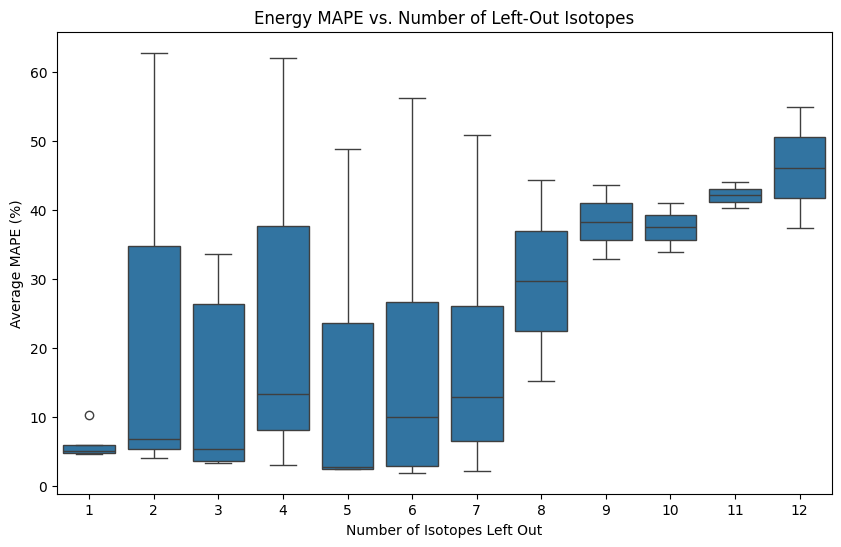

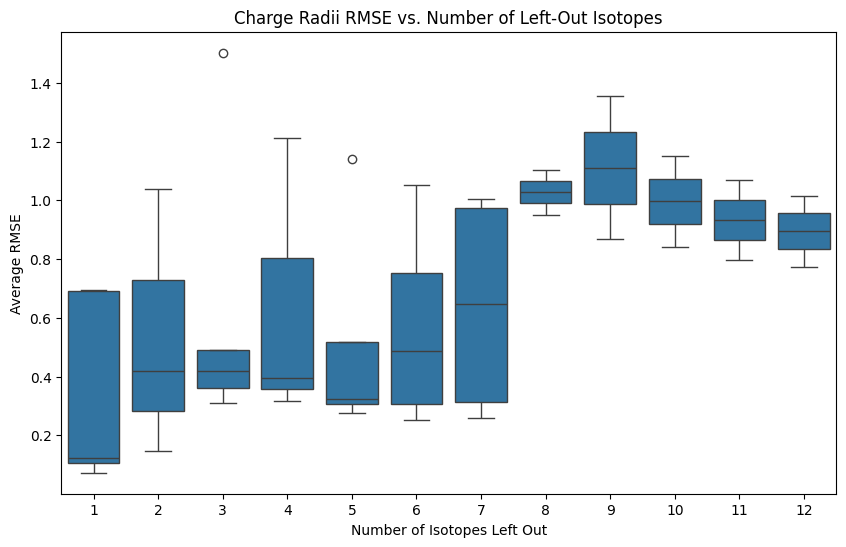

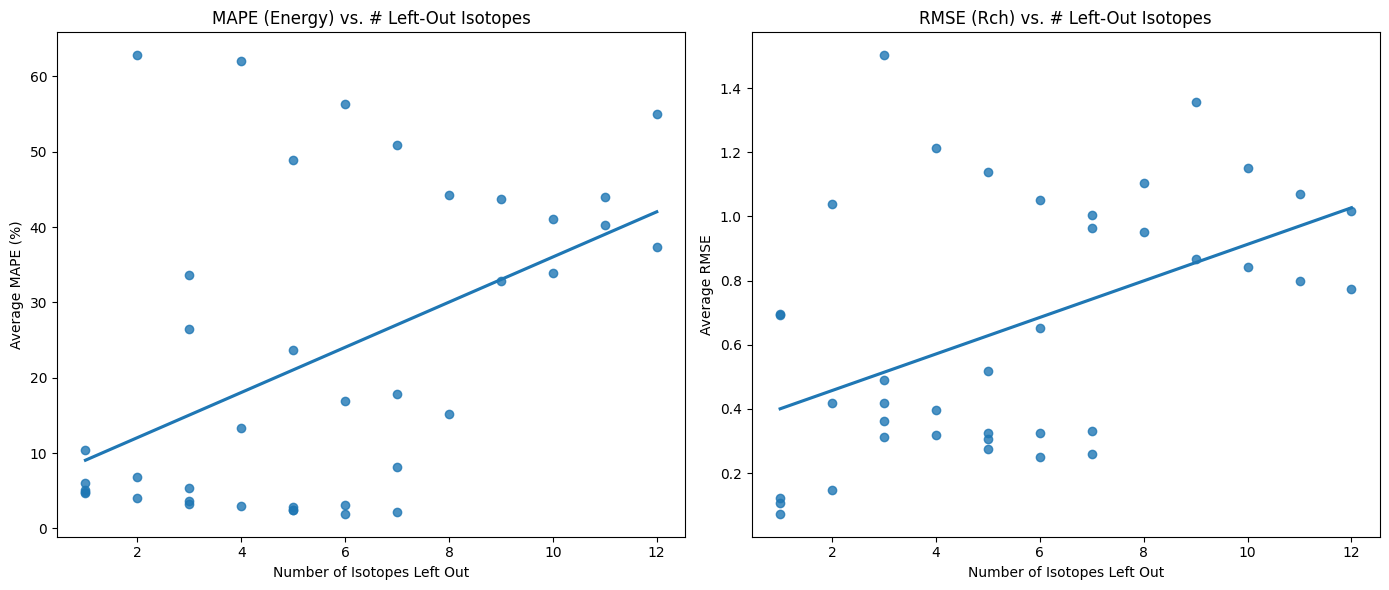

Pearson correlation (n_left vs MAPE): 0.485 (p=0.00177)
Pearson correlation (n_left vs RMSE): 0.476 (p=0.00218)


/var/folders/zg/s97g7gnj27z83xl9nrhntgxm0000gn/T/ipykernel_45098/2366132728.py:103: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="isotope", y="mape_eb", data=iso_sens, palette="viridis")


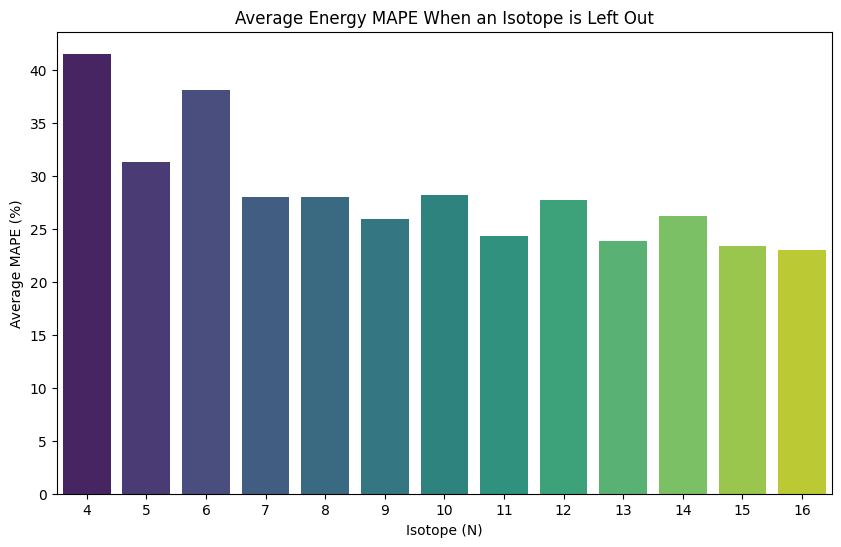

/var/folders/zg/s97g7gnj27z83xl9nrhntgxm0000gn/T/ipykernel_45098/2366132728.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="isotope", y="rmse_rch", data=iso_sens, palette="magma")


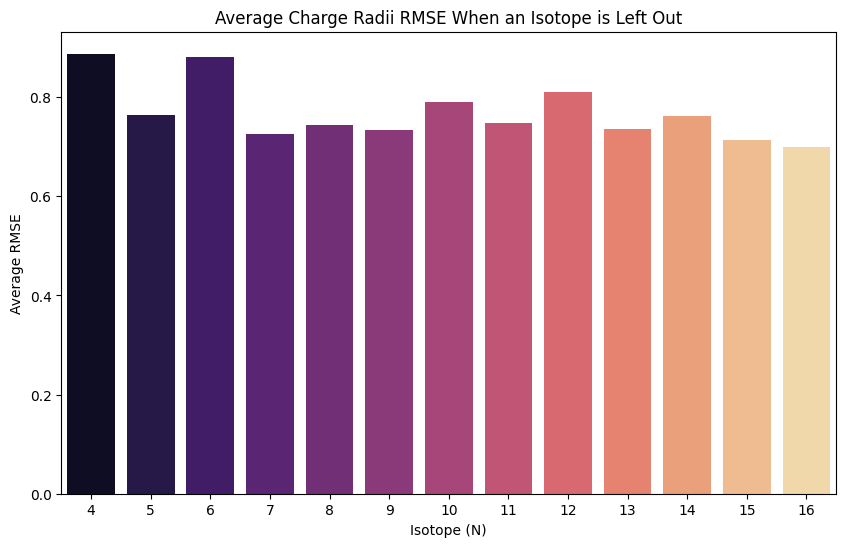

In [4]:

# --- Compute Metrics per Experiment ---

def compute_metrics(df):
    """
    Compute RMSE and MAPE metrics for energy-based (eb) and charge radii (rch)
    predictions for each fidelity (emax).
    """
    metrics = {
        "emax": [],
        "rmse_eb": [],
        "rmse_rch": [],
        "mape_eb": [],
        "mape_rch": [],
    }
    for emax in np.sort(df["emax"].unique()):
        sub = df[df["emax"] == emax]
        true_eb = sub["Energy bra"].values
        true_rch = sub["Rch"].values
        pred_eb = sub["eb_pred"].values
        pred_rch = sub["r_pred"].values
        metrics["emax"].append(emax)
        metrics["rmse_eb"].append(np.sqrt(np.mean((pred_eb - true_eb) ** 2)))
        metrics["rmse_rch"].append(np.sqrt(np.mean((pred_rch - true_rch) ** 2)))
        metrics["mape_eb"].append(np.mean(np.abs((pred_eb - true_eb) / true_eb)) * 100)
        metrics["mape_rch"].append(np.mean(np.abs((pred_rch - true_rch) / true_rch)) * 100)
    overall = {k: np.mean(v) for k, v in metrics.items() if k != "emax"}
    overall["n_expts"] = len(df)
    return metrics, overall

# Compute overall metrics for each leave-out experiment.
exp_metrics = []
for combo, group in all_predictions.groupby("leaveout_combo"):
    _, overall = compute_metrics(group)
    n_left = group["n_left"].iloc[0]
    leftout_ids = group["leftout_ids"].iloc[0]
    overall.update({"leaveout_combo": combo, "n_left": n_left, "leftout_ids": leftout_ids})
    exp_metrics.append(overall)

metrics_df = pd.DataFrame(exp_metrics)
print("Summary metrics per experiment:")
print(metrics_df)

# Save summary metrics for future reference.
metrics_df.to_csv("leaveout_experiment_metrics_summary.csv", index=False)

# --- Generate Plots ---

# (a) Boxplots: Performance vs. Number of Isotopes Left Out
plt.figure(figsize=(10, 6))
sns.boxplot(x="n_left", y="mape_eb", data=metrics_df)
plt.title("Energy MAPE vs. Number of Left-Out Isotopes")
plt.xlabel("Number of Isotopes Left Out")
plt.ylabel("Average MAPE (%)")
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x="n_left", y="rmse_rch", data=metrics_df)
plt.title("Charge Radii RMSE vs. Number of Left-Out Isotopes")
plt.xlabel("Number of Isotopes Left Out")
plt.ylabel("Average RMSE")
plt.show()

# (b) Scatter Plots and Correlations
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
sns.regplot(x="n_left", y="mape_eb", data=metrics_df, ax=axs[0], marker="o", ci=None)
axs[0].set_title("MAPE (Energy) vs. # Left-Out Isotopes")
axs[0].set_xlabel("Number of Isotopes Left Out")
axs[0].set_ylabel("Average MAPE (%)")

sns.regplot(x="n_left", y="rmse_rch", data=metrics_df, ax=axs[1], marker="o", ci=None)
axs[1].set_title("RMSE (Rch) vs. # Left-Out Isotopes")
axs[1].set_xlabel("Number of Isotopes Left Out")
axs[1].set_ylabel("Average RMSE")
plt.tight_layout()
plt.show()

corr_mape, pval_mape = pearsonr(metrics_df["n_left"], metrics_df["mape_eb"])
corr_rmse, pval_rmse = pearsonr(metrics_df["n_left"], metrics_df["rmse_rch"])
print(f"Pearson correlation (n_left vs MAPE): {corr_mape:.3f} (p={pval_mape:.3g})")
print(f"Pearson correlation (n_left vs RMSE): {corr_rmse:.3f} (p={pval_rmse:.3g})")

# (c) Sensitivity Analysis: Which Isotopes Are Most Critical?
rows = []
for _, row in metrics_df.iterrows():
    # Convert the stored left-out IDs string into a list.
    left_ids = eval(row["leftout_ids"])
    for iso in left_ids:
        rows.append({
            "isotope": iso,
            "mape_eb": row["mape_eb"],
            "rmse_rch": row["rmse_rch"],
            "n_left": row["n_left"]
        })

sensitivity_df = pd.DataFrame(rows)
iso_sens = sensitivity_df.groupby("isotope").agg({
    "mape_eb": "mean",
    "rmse_rch": "mean",
    "n_left": "count"
}).reset_index().rename(columns={"n_left": "n_experiments"})

plt.figure(figsize=(10, 6))
sns.barplot(x="isotope", y="mape_eb", data=iso_sens, palette="viridis")
plt.title("Average Energy MAPE When an Isotope is Left Out")
plt.xlabel("Isotope (N)")
plt.ylabel("Average MAPE (%)")
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x="isotope", y="rmse_rch", data=iso_sens, palette="magma")
plt.title("Average Charge Radii RMSE When an Isotope is Left Out")
plt.xlabel("Isotope (N)")
plt.ylabel("Average RMSE")
plt.show()
